In [1]:
%matplotlib inline

In [2]:
#import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
#from cv2 import VideoWriter, VideoWriter_fourcc
import pandas as pd
import torch
from scipy import signal, ndimage, spatial
from scipy.signal import correlate
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter
import math 

from scipy.interpolate import interp1d
import scipy.stats as stats
from scipy.stats import spearmanr
import seaborn as sns

## Read the SLP Scores 

In [28]:
#path = r'/home/deniz/Code/ClinicalScoreProject/NeuroFace_Dataset/ALS/SLP_Assessment_ALS.csv'

path = r'/Users/denizjafari/documents/CODE/ClinicalScore/NeuroFace_Dataset/ALS/SLP_Assessment_ALS.csv'
df = pd.read_csv(path)

df = df.drop('Unnamed: 8', axis=1)

print(len(df))
print(df.columns)
print(df['Subject ID'].unique())
df.head()

76
Index(['File Name', 'Subject ID', 'Symmetry (SLP1)', 'ROM (SLP1)',
       'Speed (SLP1)', 'Variability (SLP1)', 'Fatigue (SLP1)', 'Tot (SLP1)',
       'Symmetry (SLP2)', 'ROM (SLP2)', 'Speed (SLP2)', 'Variability (SLP2)',
       'Fatigue (SLP2)', 'Tot (SLP2)'],
      dtype='object')
['A002' 'A006' 'A008' 'A009' 'A010' 'A011' 'A012' 'A014' 'A015' 'A016'
 'A017']


,File Name,Subject ID,Symmetry (SLP1),ROM (SLP1),Speed (SLP1),Variability (SLP1),Fatigue (SLP1),Tot (SLP1),Symmetry (SLP2),ROM (SLP2),Speed (SLP2),Variability (SLP2),Fatigue (SLP2),Tot (SLP2)
0,A002_02_BBP_NORMAL_color.avi,A002,1,1,1,1,1,5,2,1,1,1,1,6
1,A002_02_DDK_PATAKA_color.avi,A002,1,1,1,1,1,5,2,2,1,2,2,9
2,A002_02_DDK_PA_color.avi,A002,1,1,1,1,1,5,2,2,1,2,2,9
3,A002_02_NSM_BLOW_color.avi,A002,2,1,1,2,1,7,1,2,2,2,1,8
4,A002_02_NSM_KISS_color.avi,A002,2,1,1,1,4,9,1,1,1,1,3,7


In [4]:
# average of the clinical scores 

df['Tot_avg'] = df.apply(lambda row: (row['Tot (SLP1)'] + row["Tot (SLP2)"])/2, axis=1)
df['Symmetry_avg'] = df.apply(lambda row: (row['Symmetry (SLP1)'] + row["Symmetry (SLP2)"])/2, axis=1)
df['ROM_avg'] = df.apply(lambda row: (row['ROM (SLP1)'] + row["ROM (SLP2)"])/2, axis=1)
df['Speed_avg'] = df.apply(lambda row: (row['Speed (SLP1)'] + row["Speed (SLP2)"])/2, axis=1)
df['Variability_avg'] = df.apply(lambda row: (row['Variability (SLP1)'] + row["Variability (SLP2)"])/2, axis=1)
df['Fatigue_avg'] = df.apply(lambda row: (row['Fatigue (SLP1)'] + row["Fatigue (SLP2)"])/2, axis=1)


In [5]:
# the ranges 

def clinical_severity(row):
    if row['Tot_avg'] ==5 :
        return 'Normal'
    if row['Tot_avg'] > 5 and row['Tot_avg'] <=10 :
        return 'Mild'
    if row['Tot_avg'] <=15 and row['Tot_avg'] > 10:
        return 'Moderate'
    if row['Tot_avg'] >15 :
        return 'Severe'
    return 'Wrong_Value'

df['Clinical_Cat'] = df.apply (lambda row: clinical_severity(row), axis=1)

df.head()

,File Name,Subject ID,Symmetry (SLP1),ROM (SLP1),Speed (SLP1),Variability (SLP1),Fatigue (SLP1),Tot (SLP1),Symmetry (SLP2),ROM (SLP2),...,Variability (SLP2),Fatigue (SLP2),Tot (SLP2),Tot_avg,Symmetry_avg,ROM_avg,Speed_avg,Variability_avg,Fatigue_avg,Clinical_Cat
0,A002_02_BBP_NORMAL_color.avi,A002,1,1,1,1,1,5,2,1,...,1,1,6,5.5,1.5,1.0,1.0,1.0,1.0,Mild
1,A002_02_DDK_PATAKA_color.avi,A002,1,1,1,1,1,5,2,2,...,2,2,9,7.0,1.5,1.5,1.0,1.5,1.5,Mild
2,A002_02_DDK_PA_color.avi,A002,1,1,1,1,1,5,2,2,...,2,2,9,7.0,1.5,1.5,1.0,1.5,1.5,Mild
3,A002_02_NSM_BLOW_color.avi,A002,2,1,1,2,1,7,1,2,...,2,1,8,7.5,1.5,1.5,1.5,2.0,1.0,Mild
4,A002_02_NSM_KISS_color.avi,A002,2,1,1,1,4,9,1,1,...,1,3,7,8.0,1.5,1.0,1.0,1.0,3.5,Mild


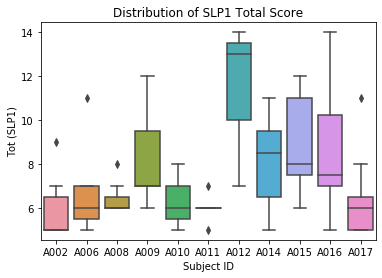

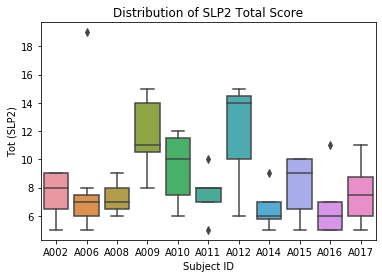

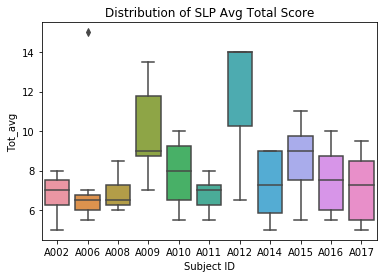

In [6]:
#g = sns.FacetGrid(df['Subject ID'], col=df['Tot_avg'])


#g.map(sns.boxplot, 'Subject ID' )
sns.boxplot(x=df['Subject ID'], y=df['Tot (SLP1)'])
plt.title('Distribution of SLP1 Total Score')
plt.show()

sns.boxplot(x=df['Subject ID'], y=df['Tot (SLP2)'])
plt.title('Distribution of SLP2 Total Score')
plt.show()

sns.boxplot(x=df['Subject ID'], y=df['Tot_avg'])
plt.title('Distribution of SLP Avg Total Score')
plt.show()

//anaconda3/envs/csc2541/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


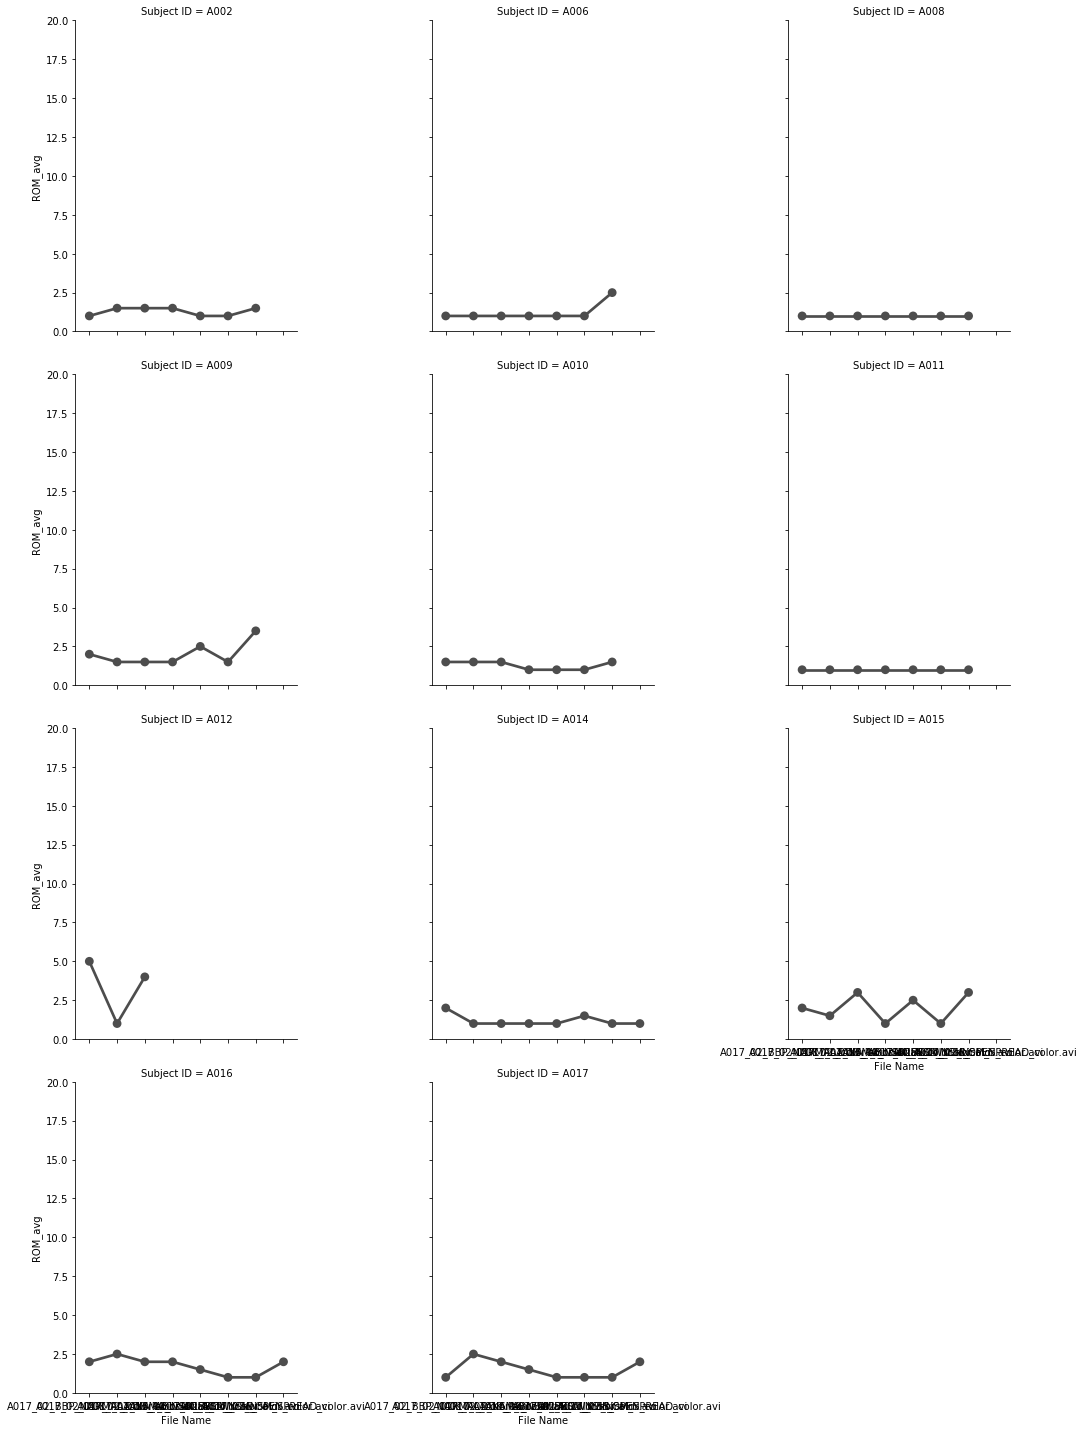

In [7]:
g = sns.FacetGrid(df, col="Subject ID", col_wrap=3, height=5, ylim=(0, 20))
g.map(sns.pointplot, "File Name", "ROM_avg",color=".3", ci=None);

//anaconda3/envs/csc2541/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


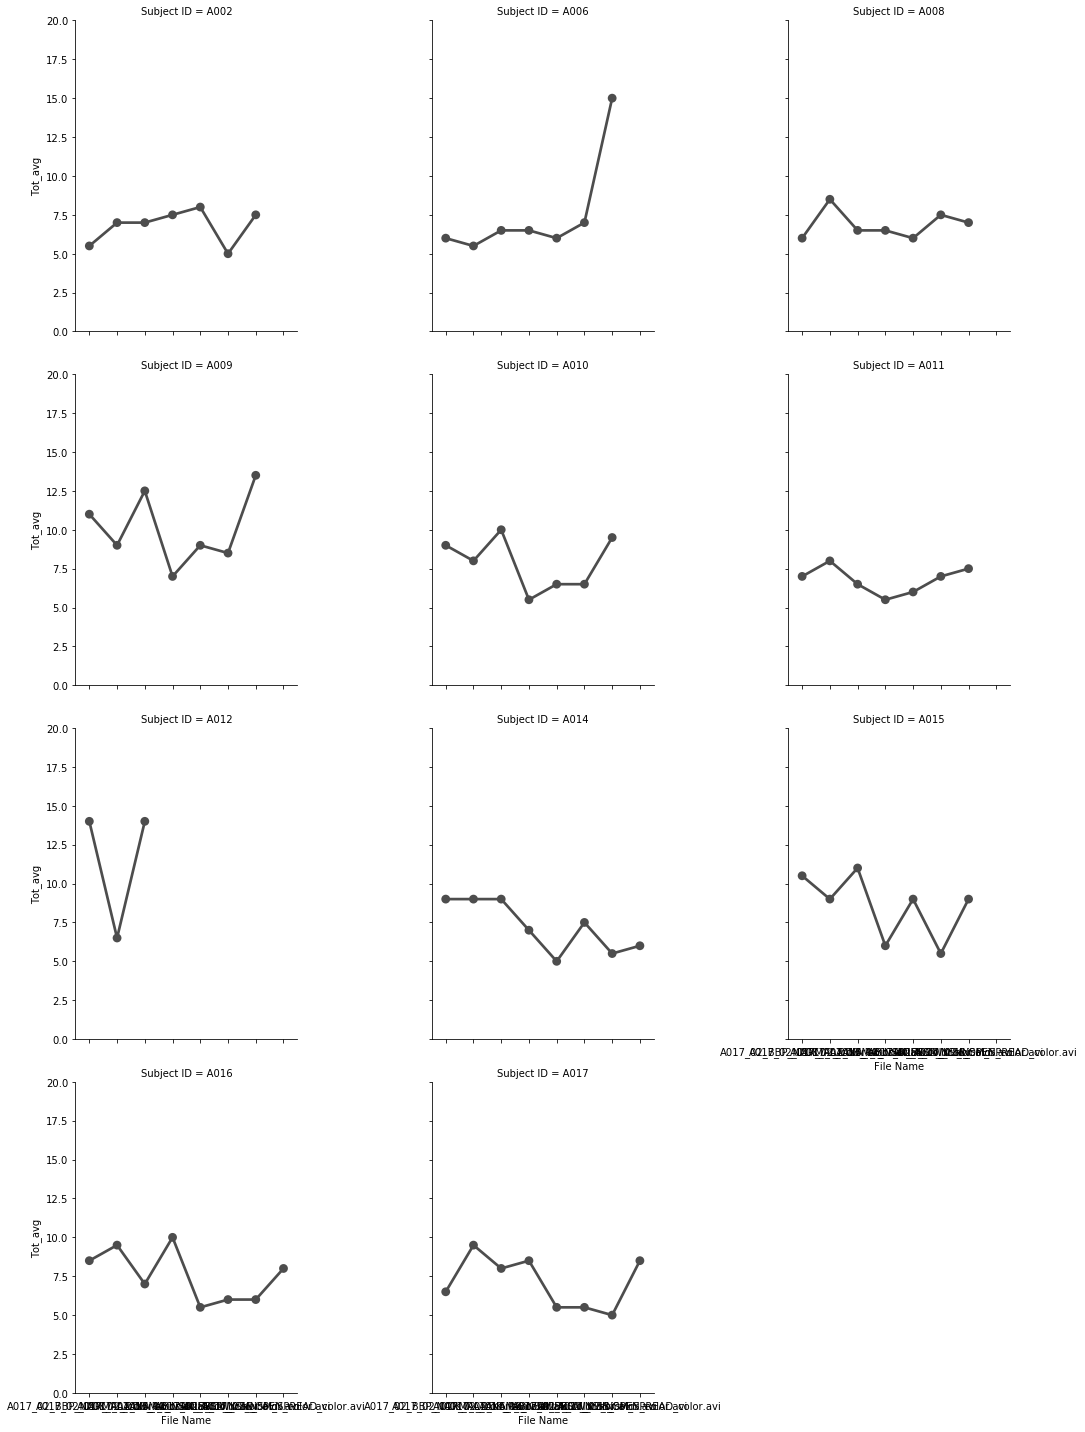

In [8]:
g = sns.FacetGrid(df, col="Subject ID", col_wrap=3, height=5, ylim=(0, 20))
g.map(sns.pointplot, "File Name", "Tot_avg",color=".3", ci=None);

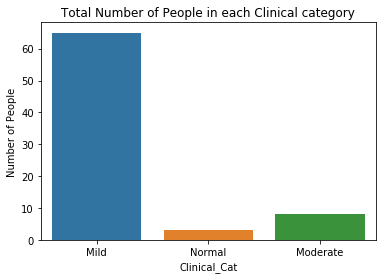

In [9]:
# lets see the severity of the oro-facial defecits in the clinical population 
sns.countplot(x='Clinical_Cat',data=df)
# set axes labels and title
plt.ylabel('Number of People')
plt.title('Total Number of People in each Clinical category')
plt.show()

Spearmans correlation: 0.373


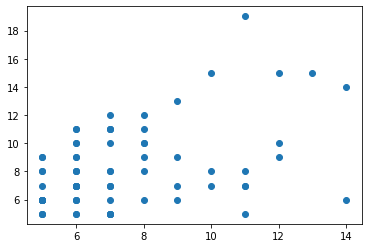

In [10]:
plt.scatter(df['Tot (SLP1)'], df['Tot (SLP2)'])

from scipy.stats import spearmanr

# calculate spearman's correlation
corr, _ = spearmanr(df['Tot (SLP1)'], df['Tot (SLP2)'])
print('Spearmans correlation: %.3f' % corr)

In [11]:
df.groupby(['Subject ID','File Name'])
#.plot(kind='scatter',x='Tot (SLP1)',y='Tot (SLP2)')

In [26]:
#path2 = r'/home/deniz/Code/ClinicalScoreProject/NeuroFace_Dataset/ALS/VID_DATASET_Clinical information_ALS.csv'

path2 = r'/Users/denizjafari/documents/CODE/ClinicalScore/NeuroFace_Dataset/ALS/VID_DATASET_Clinical information_ALS.csv'
df2 = pd.read_csv(path2)

print(len(df2))
print(df2.columns)
print(df2.SubjectID.unique())
df2.head()

10
Index(['SubjectID', 'AgeSession', 'Gender', 'DisDurDiag', 'AgeDiag',
       'DisDurON', 'AgeOnset', 'SiteOnset', 'ALSFRSTot', 'ALSFRSBulb',
       'Intell (%)', 'SpeakRate (words/min)'],
      dtype='object')
['A002' 'A006' 'A008' 'A009' 'A010' 'A011' 'A012' 'A014' 'A015' 'A017']


,SubjectID,AgeSession,Gender,DisDurDiag,AgeDiag,DisDurON,AgeOnset,SiteOnset,ALSFRSTot,ALSFRSBulb,Intell (%),SpeakRate (words/min)
0,A002,62,F,19,60,31,59,Lower limbs,31,12,100,151.72
1,A006,64,F,20,62,109,55,Upper/Lower limbs,26,12,96.36,122.68
2,A008,55,M,15,54,28,53,Upper limbs,39,11,91.82,143.17
3,A009,45,F,29,42,41,41,Lower limbs,26,7,28.18,63.28
4,A010,68,M,10,67,26,66,Upper limbs,40,12,87.27,88.61


In [13]:
path3 = r'/Users/denizjafari/documents/CODE/ClinicalScore/for_deniz.csv'

df3 = pd.read_csv(path3)

print(len(df3))
print(df3.columns)
df3.head()

117
Index(['Unnamed: 0', 'subject_id', 'task', 'type', 'rep', 'O_MAX', 'O_MIN',
       'O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3', 'Unnamed: 19',
       'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23',
       'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27',
       'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31',
       'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35',
       'Unnamed: 36'],
      dtype='object')


,Unnamed: 0,subject_id,task,type,rep,O_MAX,O_MIN,O_MAX_VEL,O_MIN_VEL,W_MAX,...,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36
0,103,OP01,BBP_NORMAL,1,1,61.587756,0.884392,31.351399,-91.131824,12.281400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,104,OP01,BBP_NORMAL,1,2,2.645485,1.033404,0.910102,-0.556077,0.913699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,105,OP01,BBP_NORMAL,1,3,2.781782,1.046640,0.797827,-0.775897,0.913249,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,106,OP01,BBP_NORMAL,1,4,2.722426,1.033732,0.784337,-1.223061,1.013992,...,S007,S008,S009,S010,S011,S012,S013,OP01,OP02,OP03
4,107,OP01,BBP_NORMAL,1,5,2.127648,1.065402,0.926365,-0.852383,0.882640,...,Symmetry,Symmetry,Symmetry,Symmetry,Symmetry,Symmetry,Symmetry,Symmetry,Symmetry,Symmetry


Features of the tasks seperated into repetitions 

In [27]:
# Standardized BBP 

path4 = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_BBP_NORMAL_standardized.csv'

bbp_df = pd.read_csv(path4)

print(len(bbp_df))
print(len(bbp_df.columns))
print(bbp_df.columns)
print(bbp_df.subject_id.unique())
bbp_df.head()

164
21
Index(['Unnamed: 0', 'subject_id', 'task', 'type', 'rep', 'LL_PATH', 'A_MEAN',
       'A_RANGE', 'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN',
       'WIDTH_VEL_MAX', 'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN',
       'HEIGHT_VEL_MAX', 'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE'],
      dtype='object')
['A001' 'A004' 'A008' 'A009' 'A010' 'A011' 'NF11' 'NF12' 'NF17' 'NF18'
 'NF02' 'NF03' 'NF04' 'NF07' 'NF08' 'NF10']


,Unnamed: 0,subject_id,task,type,rep,LL_PATH,A_MEAN,A_RANGE,A_ABS_DIFF,A_CCC,...,WIDTH_MEAN,WIDTH_VEL_MAX,WIDTH_VEL_MIN,HEIGHT_MAX,HEIGHT_MIN,HEIGHT_VEL_MAX,HEIGHT_VEL_MIN,R_SYMM,E_MEAN,E_RANGE
0,0,A001,BBP_NORMAL,1,1,-0.215870,0.136869,-0.176957,-0.613247,0.346506,...,0.295740,-0.778744,0.780765,-0.227367,-0.191740,0.461185,-0.072427,0.972327,0.225458,-0.483531
1,1,A001,BBP_NORMAL,1,2,-0.337222,0.153676,-0.104392,-0.752957,0.388989,...,0.025944,-0.646191,0.246260,0.010325,0.090365,0.599250,0.290242,0.902949,0.013954,0.056602
2,2,A001,BBP_NORMAL,1,3,-0.358441,0.181225,0.066887,-0.756891,0.428300,...,0.335881,-0.795324,0.090749,0.014513,-0.174053,0.836964,-0.224743,1.047625,0.211090,0.029828
3,3,A001,BBP_NORMAL,1,4,-0.149013,0.200017,0.008100,-0.640854,0.335648,...,-0.032402,-0.594184,0.391334,0.022435,0.129439,0.521974,-0.424736,1.019186,0.305663,-0.174827
4,4,A001,BBP_NORMAL,1,5,-0.205890,0.058934,0.078543,-0.718055,0.408061,...,-0.320478,-0.834177,0.305702,-0.053124,-0.237576,-0.044338,-0.031636,0.708230,0.403195,-0.220440


In [24]:
# Standardized Open

path6 = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_NSM_OPEN_standardized.csv'

open_df = pd.read_csv(path6)

print(len(open_df))
print(len(open_df.columns))
print(open_df.subject_id.unique())
print(open_df.columns)
open_df.head()

79
21
['A001' 'A004' 'A008' 'A009' 'A010' 'A011' 'NF11' 'NF12' 'NF17' 'NF18'
 'NF01' 'NF02' 'NF03' 'NF04' 'NF07' 'NF10']
Index(['Unnamed: 0', 'subject_id', 'task', 'type', 'rep', 'LL_PATH', 'A_MEAN',
       'A_RANGE', 'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN',
       'WIDTH_VEL_MAX', 'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN',
       'HEIGHT_VEL_MAX', 'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE'],
      dtype='object')


,Unnamed: 0,subject_id,task,type,rep,LL_PATH,A_MEAN,A_RANGE,A_ABS_DIFF,A_CCC,...,WIDTH_MEAN,WIDTH_VEL_MAX,WIDTH_VEL_MIN,HEIGHT_MAX,HEIGHT_MIN,HEIGHT_VEL_MAX,HEIGHT_VEL_MIN,R_SYMM,E_MEAN,E_RANGE
0,0,A001,NSM_OPEN,1,1,-0.203141,0.993852,0.740749,0.179625,-1.146813,...,0.408442,0.139503,0.318688,0.175377,-0.096755,-0.354331,-0.216170,-1.129932,-0.046916,0.359396
1,1,A001,NSM_OPEN,1,2,-0.002774,0.995576,0.490115,-0.039255,-0.244934,...,0.653615,-0.129659,0.359342,0.430000,2.266914,-0.291962,0.052390,-0.062699,-0.426236,0.400274
2,2,A001,NSM_OPEN,1,3,0.166772,1.654185,1.047016,0.464257,-1.590620,...,0.232597,0.108865,-0.302764,0.406607,1.443018,-0.295304,-0.010295,-1.156590,-0.335211,0.064580
3,3,A001,NSM_OPEN,1,4,0.350153,1.041140,0.903658,-0.019108,-0.326361,...,0.504072,-0.151487,0.220538,0.506437,-0.103253,-0.176378,0.050260,-0.029149,-0.486190,0.926023
4,4,A001,NSM_OPEN,1,5,-0.054048,1.435868,0.840615,0.398124,-1.509214,...,1.006171,-0.050515,0.052295,0.297936,1.066448,-0.275223,-0.091375,-0.759849,0.117021,-0.771053


In [23]:
# Standardized Big Smile

path5 = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_NSM_BIGSMILE_standardized.csv'

bigs_df = pd.read_csv(path5)

print(len(bigs_df))
print(len(bigs_df.columns))
print(bigs_df.columns)
print(bigs_df.subject_id.unique())
bigs_df.head()

15
21
Index(['Unnamed: 0', 'subject_id', 'task', 'type', 'rep', 'LL_PATH', 'A_MEAN',
       'A_RANGE', 'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN',
       'WIDTH_VEL_MAX', 'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN',
       'HEIGHT_VEL_MAX', 'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE'],
      dtype='object')
['NF12' 'NF17' 'NF18']


,Unnamed: 0,subject_id,task,type,rep,LL_PATH,A_MEAN,A_RANGE,A_ABS_DIFF,A_CCC,...,WIDTH_MEAN,WIDTH_VEL_MAX,WIDTH_VEL_MIN,HEIGHT_MAX,HEIGHT_MIN,HEIGHT_VEL_MAX,HEIGHT_VEL_MIN,R_SYMM,E_MEAN,E_RANGE
0,0,NF12,NSM_BIGSMILE,0,1,-0.647143,-1.106084,-1.026269,-1.300614,0.983163,...,1.058859,0.600074,-1.917986,-1.346578,-1.328214,-1.602748,0.597776,2.211493,-0.965439,-0.034887
1,1,NF12,NSM_BIGSMILE,0,2,-0.648041,-1.041604,-1.008644,-1.316008,0.996410,...,1.097863,1.638595,-0.404843,-1.261752,-1.329128,-0.788883,0.480539,1.275817,-1.451006,1.084077
2,2,NF12,NSM_BIGSMILE,0,3,-0.674859,-1.127835,-0.995842,-1.323057,1.018527,...,1.105812,1.544017,0.936332,-1.326071,-1.394672,-1.012520,0.924377,1.649108,-1.158529,0.454298
3,3,NF12,NSM_BIGSMILE,0,4,-0.726189,-1.090939,-0.975273,-1.327510,1.028941,...,1.278111,0.826329,-0.892396,-1.292837,-1.395933,-0.734737,0.711579,0.390036,-1.442831,0.641128
4,4,NF12,NSM_BIGSMILE,0,5,-0.613090,-1.156831,-1.005889,-1.287223,0.954832,...,1.129596,0.961396,0.252825,-1.301119,-1.401749,-0.410860,0.928609,0.105198,-1.199660,0.943340


In [22]:
# Standardized Spread

path7 = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_NSM_SPREAD_standardized.csv'

spread_df = pd.read_csv(path7)

print(len(spread_df))
print(len(spread_df.columns))
print(spread_df.columns)
print(spread_df.subject_id.unique())
spread_df.head()

85
21
Index(['Unnamed: 0', 'subject_id', 'task', 'type', 'rep', 'LL_PATH', 'A_MEAN',
       'A_RANGE', 'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN',
       'WIDTH_VEL_MAX', 'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN',
       'HEIGHT_VEL_MAX', 'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE'],
      dtype='object')
['A001' 'A004' 'A008' 'A009' 'A010' 'A011' 'NF11' 'NF12' 'NF17' 'NF18'
 'NF01' 'NF02' 'NF03' 'NF04' 'NF07' 'NF08' 'NF10']


,Unnamed: 0,subject_id,task,type,rep,LL_PATH,A_MEAN,A_RANGE,A_ABS_DIFF,A_CCC,...,WIDTH_MEAN,WIDTH_VEL_MAX,WIDTH_VEL_MIN,HEIGHT_MAX,HEIGHT_MIN,HEIGHT_VEL_MAX,HEIGHT_VEL_MIN,R_SYMM,E_MEAN,E_RANGE
0,0,A001,NSM_SPREAD,1,1,-0.084762,3.768061,3.911211,0.503443,0.905987,...,-1.330155,0.301600,-1.861184,2.939696,0.637016,2.359808,-3.148106,1.937095,-2.543674,3.119480
1,1,A001,NSM_SPREAD,1,2,0.473368,1.435331,2.693424,0.058910,0.859961,...,-0.577099,-0.504073,-0.772064,2.458639,0.168603,0.908185,-2.254909,1.952276,-1.659000,2.525605
2,2,A001,NSM_SPREAD,1,3,0.764087,1.792240,2.193096,0.651024,0.682748,...,-1.065611,-0.893509,0.552644,2.380045,0.190210,0.120012,-0.606192,1.472899,-2.760724,2.786117
3,3,A001,NSM_SPREAD,1,4,0.672740,2.676219,3.045488,0.591373,0.813387,...,-0.801123,0.942367,-0.208334,2.704192,1.755796,0.882056,-0.387215,1.929510,-2.799626,2.305372
4,4,A001,NSM_SPREAD,1,5,0.905696,2.275558,2.523964,0.715960,0.778034,...,-0.985144,2.870917,0.386296,2.562377,0.183059,3.931263,-1.399323,1.894674,-2.697498,2.746735


## Stroke data

In [50]:
# SLP SCORES

path = r'/Users/denizjafari/documents/CODE/ClinicalScore/NeuroFace_Dataset/Stroke/SLP_Assessment_PS.csv'
ps_df = pd.read_csv(path)

ps_df = ps_df.drop('Unnamed: 8', axis=1)

# average of the clinical scores 

ps_df['Tot_avg'] = ps_df.apply(lambda row: (row['Tot (SLP1)'] + row["Tot (SLP2)"])/2, axis=1)
ps_df['Symmetry_avg'] = ps_df.apply(lambda row: (row['Symmetry (SLP1)'] + row["Symmetry (SLP2)"])/2, axis=1)
ps_df['ROM_avg'] = ps_df.apply(lambda row: (row['ROM (SLP1)'] + row["ROM (SLP2)"])/2, axis=1)
ps_df['Speed_avg'] = ps_df.apply(lambda row: (row['Speed (SLP1)'] + row["Speed (SLP2)"])/2, axis=1)
ps_df['Variability_avg'] = ps_df.apply(lambda row: (row['Variability (SLP1)'] + row["Variability (SLP2)"])/2, axis=1)
ps_df['Fatigue_avg'] = ps_df.apply(lambda row: (row['Fatigue (SLP1)'] + row["Fatigue (SLP2)"])/2, axis=1)



print('len: ', len(ps_df))
print(ps_df.columns)
print(ps_df['Subject ID'].unique())
ps_df.head()

len:  105
Index(['File Name', 'Subject ID', 'Symmetry (SLP1)', 'ROM (SLP1)',
       'Speed (SLP1)', 'Variability (SLP1)', 'Fatigue (SLP1)', 'Tot (SLP1)',
       'Symmetry (SLP2)', 'ROM (SLP2)', 'Speed (SLP2)', 'Variability (SLP2)',
       'Fatigue (SLP2)', 'Tot (SLP2)', 'Tot_avg', 'Symmetry_avg', 'ROM_avg',
       'Speed_avg', 'Variability_avg', 'Fatigue_avg'],
      dtype='object')
['OP01' 'OP02' 'OP03' 'S001' 'S002' 'S003' 'S005' 'S006' 'S007' 'S008'
 'S009' 'S011' 'S012' 'S013']


,File Name,Subject ID,Symmetry (SLP1),ROM (SLP1),Speed (SLP1),Variability (SLP1),Fatigue (SLP1),Tot (SLP1),Symmetry (SLP2),ROM (SLP2),Speed (SLP2),Variability (SLP2),Fatigue (SLP2),Tot (SLP2),Tot_avg,Symmetry_avg,ROM_avg,Speed_avg,Variability_avg,Fatigue_avg
0,OP01_02_BBP_NORMAL_color.avi,OP01,2,2,3,2,2,11,2,1,2,1,1,7,9.0,2.0,1.5,2.5,1.5,1.5
1,OP01_02_DDK_PATAKA_color.avi,OP01,2,1,3,3,2,11,2,1,2,2,1,8,9.5,2.0,1.0,2.5,2.5,1.5
2,OP01_02_DDK_PA_color.avi,OP01,2,2,2,2,2,10,3,2,3,1,1,10,10.0,2.5,2.0,2.5,1.5,1.5
3,OP01_02_NSM_BIGSMILE_color.avi,OP01,2,2,2,1,1,8,2,1,1,1,1,6,7.0,2.0,1.5,1.5,1.0,1.0
4,OP01_02_NSM_BROW_color.avi,OP01,1,1,1,1,2,6,1,2,1,1,1,6,6.0,1.0,1.5,1.0,1.0,1.5


In [55]:
tasks = ['BBP_NORMAL', 'PA', 'PATAKA', 'BLOW', 'KISS', 'OPEN', 'SPREAD', 'BIGSMILE', 'BROW']

def task_labeler(row):
    for t in tasks: 
        if t in row: 
            return t
    

ps_df['task'] = [task_labeler(x) for x in ps_df['File Name']]

ps_df.head()

,File Name,Subject ID,Symmetry (SLP1),ROM (SLP1),Speed (SLP1),Variability (SLP1),Fatigue (SLP1),Tot (SLP1),Symmetry (SLP2),ROM (SLP2),...,Variability (SLP2),Fatigue (SLP2),Tot (SLP2),Tot_avg,Symmetry_avg,ROM_avg,Speed_avg,Variability_avg,Fatigue_avg,task
0,OP01_02_BBP_NORMAL_color.avi,OP01,2,2,3,2,2,11,2,1,...,1,1,7,9.0,2.0,1.5,2.5,1.5,1.5,BBP_NORMAL
1,OP01_02_DDK_PATAKA_color.avi,OP01,2,1,3,3,2,11,2,1,...,2,1,8,9.5,2.0,1.0,2.5,2.5,1.5,PA
2,OP01_02_DDK_PA_color.avi,OP01,2,2,2,2,2,10,3,2,...,1,1,10,10.0,2.5,2.0,2.5,1.5,1.5,PA
3,OP01_02_NSM_BIGSMILE_color.avi,OP01,2,2,2,1,1,8,2,1,...,1,1,6,7.0,2.0,1.5,1.5,1.0,1.0,BIGSMILE
4,OP01_02_NSM_BROW_color.avi,OP01,1,1,1,1,2,6,1,2,...,1,1,6,6.0,1.0,1.5,1.0,1.0,1.5,BROW


In [56]:
ps_df_bbp = ps_df[ps_df['task']== 'BBP_NORMAL']

In [60]:
print(ps_df.shape)

print(ps_df_bbp.shape)
ps_df_bbp.head()

(105, 21)
(14, 21)


,File Name,Subject ID,Symmetry (SLP1),ROM (SLP1),Speed (SLP1),Variability (SLP1),Fatigue (SLP1),Tot (SLP1),Symmetry (SLP2),ROM (SLP2),...,Variability (SLP2),Fatigue (SLP2),Tot (SLP2),Tot_avg,Symmetry_avg,ROM_avg,Speed_avg,Variability_avg,Fatigue_avg,task
0,OP01_02_BBP_NORMAL_color.avi,OP01,2,2,3,2,2,11,2,1,...,1,1,7,9.0,2.0,1.5,2.5,1.5,1.5,BBP_NORMAL
8,OP02_02_BBP_NORMAL_color.avi,OP02,2,1,2,1,1,7,2,1,...,1,1,7,7.0,2.0,1.0,2.0,1.0,1.0,BBP_NORMAL
16,OP03_02_BBP_NORMAL_color.avi,OP03,1,1,1,1,1,5,1,1,...,1,1,5,5.0,1.0,1.0,1.0,1.0,1.0,BBP_NORMAL
24,S001_02_BBP_NORMAL_color.avi,S001,3,1,2,4,1,11,3,2,...,4,2,13,12.0,3.0,1.5,2.0,4.0,1.5,BBP_NORMAL
31,S002_02_BBP_NORMAL_color.avi,S002,3,2,4,4,1,14,3,2,...,4,1,13,13.5,3.0,2.0,3.5,4.0,1.0,BBP_NORMAL


In [48]:
path = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_all_finetuned/metric_output_BBP_NORMAL_standardized.csv'

s_bbp_df = pd.read_csv(path)

print('len: ' , len(s_bbp_df))
print(len(s_bbp_df.columns))
print(s_bbp_df.columns)
print(s_bbp_df.subject_id.unique())
s_bbp_df.head()

len:  457
19
Index(['Unnamed: 0', 'subject_id', 'task', 'type', 'rep', 'O_MAX', 'O_MIN',
       'O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3'],
      dtype='object')
['NF11' 'NF12' 'NF13' 'NF14' 'NF15' 'NF16' 'NF17' 'NF18' 'NF19' 'NF20'
 'NF21' 'NF22' 'NF24' 'NF26' 'NF27' 'NF00' 'NF02' 'NF03' 'NF04' 'NF05'
 'NF06' 'NF07' 'NF08' 'NF09' 'NF10' 'OP01' 'OP02' 'OP03' 'OP05' 'OP06'
 'OP07' 'OP08' 'OP09' 'OP10' 'OP12' 'S001' 'S002' 'S003' 'S005' 'S006'
 'S007' 'S008' 'S009' 'S010' 'S013']


,Unnamed: 0,subject_id,task,type,rep,O_MAX,O_MIN,O_MAX_VEL,O_MIN_VEL,W_MAX,W_MIN,W_MAX_VEL,W_MIN_VEL,A_MOUTH,R_LCRC,D_0,D_1,D_2,D_3
0,0,NF11,BBP_NORMAL,0,1,-0.113784,0.101184,-0.094766,0.104099,-0.102612,-0.192593,-0.096646,0.090399,-0.073213,-0.775730,-0.136865,-0.087322,-0.140752,-0.099467
1,1,NF11,BBP_NORMAL,0,2,-0.126145,-0.010132,-0.074803,0.113766,-0.119388,-0.247239,-0.108232,0.106958,-0.128275,-1.209708,-0.082621,-0.092922,-0.143255,-0.113881
2,2,NF11,BBP_NORMAL,0,3,-0.142563,0.211797,-0.079372,0.072099,-0.131001,-0.292026,-0.131967,0.108595,-0.154483,-0.241926,-0.096537,-0.089414,-0.122998,-0.152515
3,3,NF11,BBP_NORMAL,0,4,-0.140305,0.189925,-0.053704,0.094888,-0.128350,-0.105882,-0.126109,0.103573,-0.058588,-0.931032,-0.143598,-0.092836,-0.121812,-0.119750
4,4,NF11,BBP_NORMAL,0,5,-0.152125,0.027831,-0.087530,0.123958,-0.072734,0.242131,-0.099216,0.078855,0.002796,0.028873,-0.130839,-0.061820,-0.137479,-0.169899


In [65]:
df_f = s_bbp_df.merge(ps_df_bbp, how= 'inner', left_on='subject_id', right_on='Subject ID')

print(df_f.size)
print(df_f.shape)
print(ps_df_bbp.shape)
print(s_bbp_df.shape)
print('len: ', len(df_f))

print(df_f.Tot_avg.isnull().count())

df_f.Tot_avg

4680
(117, 40)
(14, 21)
(457, 19)
len:  117
117


0      9.0
1      9.0
2      9.0
3      9.0
4      9.0
      ... 
112    7.5
113    7.5
114    7.5
115    7.5
116    7.5
Name: Tot_avg, Length: 117, dtype: float64

In [61]:
s_bbp_df.task.unique()

array(['BBP_NORMAL'], dtype=object)

In [66]:
df_f.head()

,Unnamed: 0,subject_id,task_x,type,rep,O_MAX,O_MIN,O_MAX_VEL,O_MIN_VEL,W_MAX,...,Variability (SLP2),Fatigue (SLP2),Tot (SLP2),Tot_avg,Symmetry_avg,ROM_avg,Speed_avg,Variability_avg,Fatigue_avg,task_y
0,258,OP01,BBP_NORMAL,1,1,7.341936,-0.504500,2.623839,-7.979108,5.724481,...,1,1,7,9.0,2.0,1.5,2.5,1.5,1.5,BBP_NORMAL
1,259,OP01,BBP_NORMAL,1,2,-0.068703,0.151367,-0.066905,0.103075,-0.187590,...,1,1,7,9.0,2.0,1.5,2.5,1.5,1.5,BBP_NORMAL
2,260,OP01,BBP_NORMAL,1,3,-0.051567,0.209626,-0.076829,0.083460,-0.187825,...,1,1,7,9.0,2.0,1.5,2.5,1.5,1.5,BBP_NORMAL
3,261,OP01,BBP_NORMAL,1,4,-0.059029,0.152812,-0.078021,0.043559,-0.135430,...,1,1,7,9.0,2.0,1.5,2.5,1.5,1.5,BBP_NORMAL
4,262,OP01,BBP_NORMAL,1,5,-0.133809,0.292205,-0.065467,0.076636,-0.203743,...,1,1,7,9.0,2.0,1.5,2.5,1.5,1.5,BBP_NORMAL


In [41]:
df_f.subject_id.unique()

array(['OP01', 'OP02', 'OP03', 'S001', 'S002', 'S003', 'S005', 'S006',
       'S007', 'S008', 'S009', 'S013'], dtype=object)

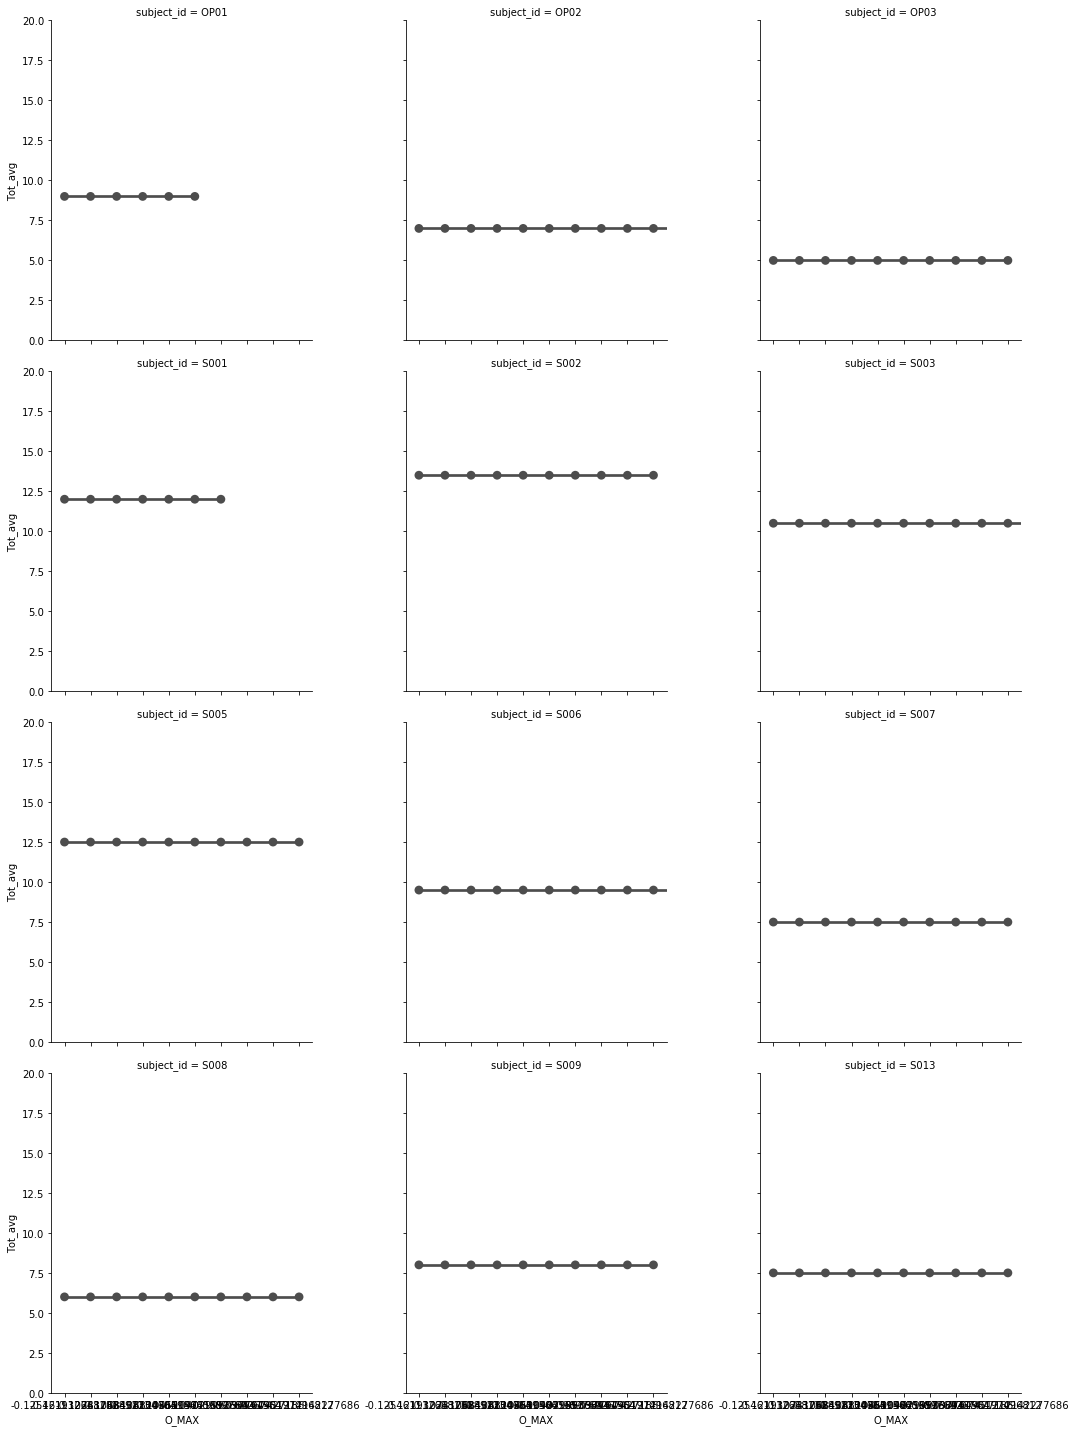

In [68]:
g = sns.FacetGrid(df_f, col="subject_id", col_wrap=3, height=5, ylim=(0, 20))
g.map(sns.pointplot, "O_MAX", "Tot_avg",color=".3", ci=None);

Spearmans correlation: 0.492


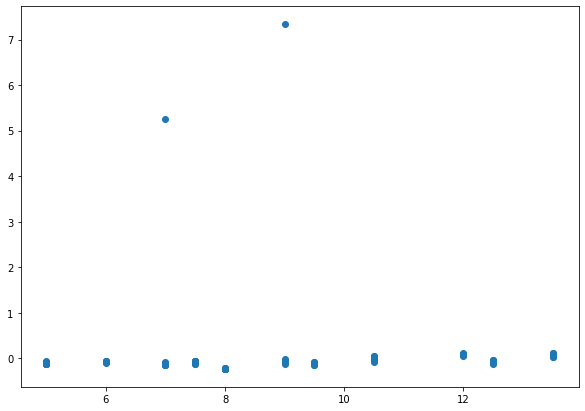

In [71]:
ax, figure = plt.subplots(figsize=(10,7))
plt.scatter(df_f['Tot_avg'], df_f["O_MAX"])

from scipy.stats import spearmanr

# calculate spearman's correlation
corr, _ = spearmanr(df_f["O_MAX"], df_f['Tot_avg'])
print('Spearmans correlation: %.3f' % corr)

In [30]:
path = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_database_finetuned/metric_output_BBP_NORMAL_standardized.csv'

s_bbp2_df = pd.read_csv(path)

print(len(s_bbp2_df))
print(len(s_bbp2_df.columns))
print(s_bbp2_df.columns)
print(s_bbp2_df.subject_id.unique())
s_bbp2_df.head()

220
19
Index(['Unnamed: 0', 'subject_id', 'task', 'type', 'rep', 'O_MAX', 'O_MIN',
       'O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3'],
      dtype='object')
['NF11' 'NF12' 'NF17' 'NF18' 'NF02' 'NF03' 'NF04' 'NF07' 'NF08' 'NF10'
 'OP01' 'OP02' 'OP03' 'S001' 'S002' 'S003' 'S005' 'S006' 'S007' 'S008'
 'S009' 'S013']


,Unnamed: 0,subject_id,task,type,rep,O_MAX,O_MIN,O_MAX_VEL,O_MIN_VEL,W_MAX,W_MIN,W_MAX_VEL,W_MIN_VEL,A_MOUTH,R_LCRC,D_0,D_1,D_2,D_3
0,0,NF11,BBP_NORMAL,0,1,-0.153850,0.067469,-0.127571,0.114557,-0.174261,-0.132163,-0.153166,0.146051,-0.085870,-0.822195,-0.323373,-0.299220,-0.382514,-0.204507
1,1,NF11,BBP_NORMAL,0,2,-0.173778,-0.036784,-0.079753,0.131914,-0.205970,-0.199355,-0.175930,0.186285,-0.142509,-1.292253,-0.207868,-0.333824,-0.389672,-0.239242
2,2,NF11,BBP_NORMAL,0,3,-0.200246,0.171062,-0.090696,0.057104,-0.227919,-0.254424,-0.222564,0.190262,-0.169468,-0.244012,-0.237501,-0.312145,-0.331760,-0.332348
3,3,NF11,BBP_NORMAL,0,4,-0.196607,0.150579,-0.029215,0.098019,-0.222909,-0.025545,-0.211056,0.178060,-0.070825,-0.990408,-0.337710,-0.333296,-0.328368,-0.253388
4,4,NF11,BBP_NORMAL,0,5,-0.215663,-0.001229,-0.110237,0.150213,-0.117786,0.402364,-0.158217,0.118003,-0.007682,0.049300,-0.310541,-0.141619,-0.373157,-0.374241
